In [1]:
import pandas as pd
import numpy as np
import pywt
import matplotlib.pyplot as plt

In [2]:
# Load the data
#file_path = '23.csv'
#data = pd.read_csv(file_path)
data = pd.read_csv('database/subset.txt', sep=';')

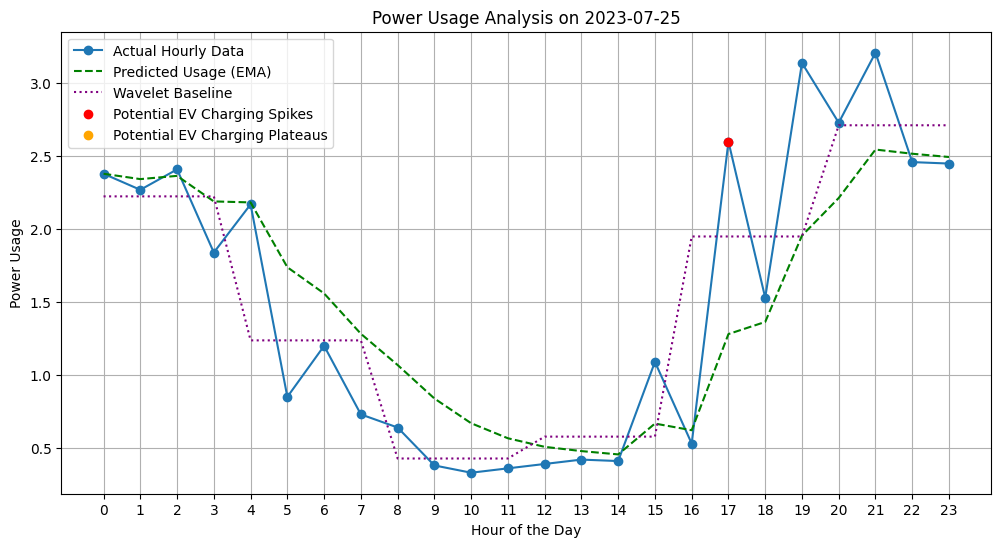

In [6]:
# Convert YYYYMMDD to datetime format
data['Date'] = pd.to_datetime(data['YYYYMMDD'], format='%Y%m%d')
specified_date = '2023-07-25'
selected_day = data[data['Date'] == pd.to_datetime(specified_date)]

# Setup thresholds and other constants
wattage_threshold = 2.4
excess_over_ema = 0.5
excess_over_wavelet = 1
plateau_duration = 3  # hours

if not selected_day.empty:
    hourly_data = selected_day.iloc[0, 4:28].values.astype(float)
    coeffs = pywt.wavedec(hourly_data, 'db1', level=2)
    approx = coeffs[0]
    details = coeffs[1:]

    ema_data = pd.Series(hourly_data).ewm(span=5, adjust=False).mean()
    wavelet_base = pywt.waverec([approx] + [np.zeros_like(d) for d in details], 'db1')

    spikes = []
    plateaus = []
    count = 0  # To count consecutive hours above thresholds

    for i in range(1, len(hourly_data) - 1):
        if (hourly_data[i] > ema_data[i] + excess_over_ema and 
            hourly_data[i] > hourly_data[i-1] + 0.3 * hourly_data[i-1] and 
            hourly_data[i] > hourly_data[i+1] + 0.3 * hourly_data[i+1] and
            hourly_data[i] > wattage_threshold):
            spikes.append(i)

        if (hourly_data[i] > wavelet_base[i] + excess_over_wavelet):
            count += 1
        else:
            if count >= plateau_duration:
                plateaus.extend(range(i-count, i))
            count = 0

    # Check if the last hours form a plateau
    if count >= plateau_duration:
        plateaus.extend(range(len(hourly_data) - count, len(hourly_data)))
    
    # Visualization
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(hourly_data, label='Actual Hourly Data', marker='o', linestyle='-')
    ax.plot(ema_data, label='Predicted Usage (EMA)', linestyle='--', color='green')
    ax.plot(wavelet_base, label='Wavelet Baseline', color='purple', linestyle=':')
    ax.scatter(spikes, [hourly_data[i] for i in spikes], color='red', label='Potential EV Charging Spikes', zorder=5)
    ax.scatter(plateaus, [hourly_data[i] for i in plateaus], color='orange', label='Potential EV Charging Plateaus', zorder=5)
    ax.set_title(f'Power Usage Analysis on {specified_date}')
    ax.set_xlabel('Hour of the Day')
    ax.set_ylabel('Power Usage')
    ax.legend()
    plt.xticks(ticks=range(24), labels=[f'{i}' for i in range(24)])
    plt.grid(True)
    plt.show()
else:
    print(f"No data available for {specified_date}. Please select another date.")

In [7]:
# Prepare to aggregate results
charging_days = []
daily_charging_times = []

# Process each day's data
for specified_date in pd.date_range(start=data['Date'].min(), end=data['Date'].max()):
    selected_day = data[data['Date'] == specified_date]

    if not selected_day.empty:
        hourly_data = selected_day.iloc[0, 4:28].values.astype(float)
        coeffs = pywt.wavedec(hourly_data, 'db1', level=2)
        approx = coeffs[0]
        details = coeffs[1:]

        ema_data = pd.Series(hourly_data).ewm(span=5, adjust=False).mean()
        wavelet_base = pywt.waverec([approx] + [np.zeros_like(d) for d in details], 'db1')

        spikes = []
        plateaus = []
        count = 0  # To count consecutive hours above thresholds
        charging_hours = []

        for i in range(1, len(hourly_data) - 1):
            if (hourly_data[i] > ema_data[i] + excess_over_ema and 
                hourly_data[i] > hourly_data[i-1] + 0.3 * hourly_data[i-1] and 
                hourly_data[i] > hourly_data[i+1] + 0.3 * hourly_data[i+1] and
                hourly_data[i] > wattage_threshold):
                spikes.append(i)
                charging_hours.append(i)

            if (hourly_data[i] > wavelet_base[i] + excess_over_wavelet):
                count += 1
            else:
                if count >= plateau_duration:
                    plateaus.extend(range(i-count, i))
                    charging_hours.extend(range(i-count, i))
                count = 0

        # Check if the last hours form a plateau
        if count >= plateau_duration:
            plateaus.extend(range(len(hourly_data) - count, len(hourly_data)))
            charging_hours.extend(range(len(hourly_data) - count, len(hourly_data)))

        if spikes or plateaus:
            charging_days.append(specified_date.strftime('%Y-%m-%d'))
            daily_charging_times.append(charging_hours)
            
# Calculate statistics
total_charging_days = len(charging_days)
total_days = len(data['Date'].dt.date.unique())
percentage_of_days_charging = (total_charging_days / total_days) * 100

print(f"Total days with charging: {total_charging_days}")
print(f"Total days analyzed: {total_days}")
print(f"Percentage of days with charging: {percentage_of_days_charging:.2f}%")

Total days with charging: 203
Total days analyzed: 365
Percentage of days with charging: 55.62%


In [5]:
charging_days

['2023-01-01',
 '2023-01-02',
 '2023-01-03',
 '2023-01-05',
 '2023-01-07',
 '2023-01-08',
 '2023-01-12',
 '2023-01-13',
 '2023-01-14',
 '2023-01-15',
 '2023-01-17',
 '2023-01-19',
 '2023-01-21',
 '2023-01-22',
 '2023-01-25',
 '2023-01-28',
 '2023-01-29',
 '2023-02-01',
 '2023-02-02',
 '2023-02-03',
 '2023-02-04',
 '2023-02-05',
 '2023-02-06',
 '2023-02-07',
 '2023-02-08',
 '2023-02-09',
 '2023-02-10',
 '2023-02-11',
 '2023-02-12',
 '2023-02-13',
 '2023-02-14',
 '2023-02-16',
 '2023-02-17',
 '2023-02-19',
 '2023-02-20',
 '2023-02-21',
 '2023-02-22',
 '2023-02-23',
 '2023-02-24',
 '2023-02-25',
 '2023-02-26',
 '2023-02-27',
 '2023-02-28',
 '2023-03-01',
 '2023-03-02',
 '2023-03-03',
 '2023-03-04',
 '2023-03-05',
 '2023-03-06',
 '2023-03-07',
 '2023-03-08',
 '2023-03-09',
 '2023-03-10',
 '2023-03-11',
 '2023-03-12',
 '2023-03-13',
 '2023-03-14',
 '2023-03-15',
 '2023-03-16',
 '2023-03-17',
 '2023-03-18',
 '2023-03-19',
 '2023-03-20',
 '2023-03-21',
 '2023-03-22',
 '2023-03-23',
 '2023-03-

In [8]:
daily_charging_times

[[13],
 [20],
 [12],
 [13],
 [11, 13, 18],
 [15],
 [12, 18],
 [18],
 [10, 18],
 [16],
 [22],
 [15, 18],
 [11, 14, 17],
 [15, 22],
 [18],
 [10, 17],
 [9, 11],
 [5, 8, 11, 13],
 [5],
 [5, 15, 17],
 [16],
 [10, 16],
 [5, 16],
 [5, 15],
 [5],
 [15],
 [5, 9],
 [10, 16],
 [9],
 [5, 19],
 [5, 7],
 [5, 17],
 [5],
 [7, 8, 9],
 [8, 17, 19],
 [5, 16, 19],
 [5],
 [7, 15],
 [5],
 [9, 18],
 [11, 17],
 [5, 7],
 [5, 15, 18],
 [5, 8],
 [5, 17],
 [5],
 [12, 16],
 [10, 15],
 [5, 7],
 [5, 15],
 [5, 12],
 [5],
 [5],
 [7, 11],
 [13, 17],
 [4, 14],
 [4, 8, 18],
 [4, 8],
 [4, 7, 17],
 [4],
 [7],
 [7, 10],
 [4, 6],
 [4, 14, 17],
 [4],
 [4, 14],
 [4, 6, 17],
 [9, 12],
 [9, 14],
 [4],
 [4, 6, 14],
 [4],
 [4],
 [4, 14, 19],
 [9, 15],
 [9, 12, 14],
 [4],
 [4, 14],
 [4],
 [9, 16],
 [21],
 [4, 14],
 [4, 19],
 [4],
 [4, 6],
 [4],
 [8, 12],
 [10, 18],
 [4],
 [14],
 [4, 14, 18],
 [14, 17],
 [4],
 [11, 18],
 [12],
 [4],
 [4],
 [4, 8],
 [4],
 [7, 9, 15, 17],
 [8],
 [17],
 [4],
 [4, 14],
 [6, 12],
 [11],
 [4],
 [4, 6],
 [